# Exploration 1: Darcy flow on random binary conductivity fields

Okay, so this is the real catalyst for this work. From last semester Ty presented one piece of recent work [published here](https://doi.org/10.3390/w13121668). I'm not so much building off of the strain of research done in the paper, but more from a conceptual level following up. So, the setup is as follows: 

<img src="assets/grid_setup.png" width="400">

Where the grey cells are low conductivity and the white cells are high conductivity. The goal is to see how the flow field changes as we change the fraction of low conductivity cells, along side how permeable they are. To accomplish  this task I wrote a little 2d Darcy flow solver, and additionally calculate the effective conductivity. I was drawn to this problem particularly from this figure in the paper:

<img src="assets/k_distribution.png" width="400">

The spread on the vertical axis got me a bit curious, since completely random fields ought not produce this dispersion for a problem like Darcy flow (aka a diffusion problem). So, I set out to see if I could reproduce this figure, and then see if I could reproduce the effective conductivity results. After some experimentation I think this dispersion is just a result of the grid resolution. For a totally random field we will see that there is "general" curve that things follow, provided the grid is fine enough.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from src.binary_grids import create_random_binary_grid, assign_k_values
from src.darcy_flow_problem_2d import solve_flow_problem, calculate_keff

def run_simulation(
    size=15, 
    percent_high_k=50, 
    k_high=1.0, 
    k_low=0.001, 
    left_head=2.0, 
    right_head=1.0
):
    """
    Run complete simulation for a given set of parameters on
    a random binary grid.
    
    Args:
        size (int): Grid size
        percent_high_k (float): Percentage of high K cells
        k_high (float): High conductivity value
        k_low (float): Low conductivity value
        left_head (float): Left boundary head
        right_head (float): Right boundary head
        
    Returns:
        tuple: (K_effective, head distribution, K distribution)
    """
    # Create binary grid and assign K values
    binary_grid = create_random_binary_grid(size, percent_high_k)
    k_grid = assign_k_values(binary_grid, k_high, k_low)
    
    # Solve flow problem
    head, flow_left, flow_right = solve_flow_problem(k_grid, left_head, right_head)
    
    # Use average of left and right flows
    avg_flow = (abs(flow_left) + abs(flow_right)) / 2
    
    # Calculate effective K
    k_eff = calculate_keff(avg_flow, domain_size=size)
    
    return k_eff, head, k_grid

In [75]:
n_iters = 100
grid_size = 500
k_low_vals = [1e-2,  1e-3, 1e-4, 1e-5, 1e-6]

all_k_eff = {}
all_frac = {}
all_k_eff_normed = {}

for k_low in k_low_vals:
    all_k_eff[k_low] = np.zeros(n_iters)
    all_frac[k_low] = np.zeros(n_iters)
    all_k_eff_normed[k_low] = np.zeros(n_iters)
    for _ in range(n_iters):
        percent_high_k = np.random.uniform(0, 100)
        k_eff, head, k_grid = run_simulation(size=grid_size, percent_high_k=percent_high_k, k_low=k_low)
        all_k_eff[k_low][_] = k_eff
        all_frac[k_low][_] = percent_high_k
        all_k_eff_normed[k_low][_] = (k_eff - k_low) / (1 - k_low)

/tmp/ipykernel_3111012/267463430.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(all_frac[k_low], all_k_eff[k_low], c=colors[i], label=f'k_low = {k_low}', marker='.')


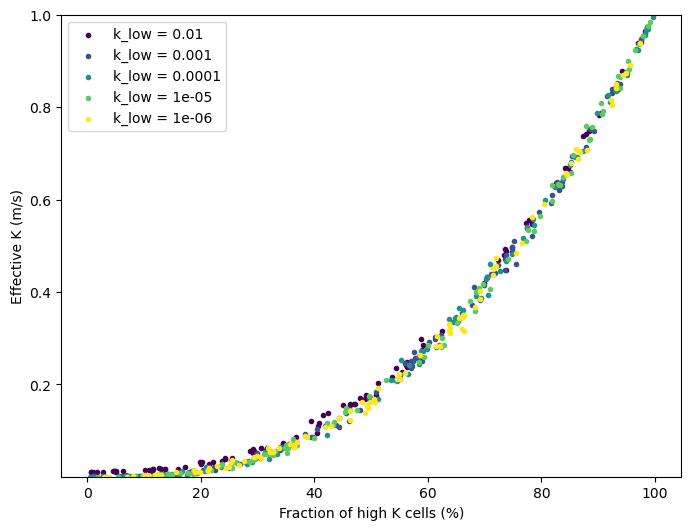

In [76]:
plt.figure(figsize=(8, 6))
num_lines = len(k_low_vals)
colors = plt.cm.viridis(np.linspace(0, 1, num_lines))

for i, k_low in enumerate(k_low_vals):
    plt.scatter(all_frac[k_low], all_k_eff[k_low], c=colors[i], label=f'k_low = {k_low}', marker='.')

plt.ylim(1e-7, 1)
#plt.semilogy()

plt.xlabel('Fraction of high K cells (%)')
plt.ylabel('Effective K (m/s)')
plt.legend()

In [59]:
n_iters = 20
grid_size = 12_000
k_low = 1e-8

# Samples more a the low end than the high end
frac_high_k = 100 * ((np.logspace(0, 1.03, 30)-1) / 10)
k_eff_list = []
head_list = []
k_grid_list = []
for phk in frac_high_k:
    k_eff, head, k_grid = run_simulation(size=grid_size, percent_high_k=phk, k_low=k_low)
    k_eff_list.append(k_eff)
    head_list.append(head)
    k_grid_list.append(k_grid)

In [60]:
frac_high_k

array([ 0.        ,  0.85218632,  1.77699479,  2.78061417,  3.86976062,
        5.05172264,  6.33440985,  7.7264059 ,  9.23702596, 10.87637899,
       12.65543544, 14.58610065, 16.6812945 , 18.95503791, 21.42254662,
       24.10033305, 27.00631677, 30.15994445, 33.58231997, 37.29634564,
       41.3268755 , 45.7008816 , 50.44763451, 55.59889921, 61.18914764,
       67.2557894 , 73.83942206, 80.98410289, 88.73764364, 97.15193052])

In [63]:
# Fit a power law to the data
def power_law(x, a, b):
    return a * x ** b

popt, pcov = curve_fit(power_law, frac_high_k, k_eff_list)
a, b = popt
a, b

/tmp/ipykernel_3111012/3880744780.py:4: RuntimeWarning: divide by zero encountered in power
  return a * x ** b


(6.7958787281905455e-06, 2.586998289945418)

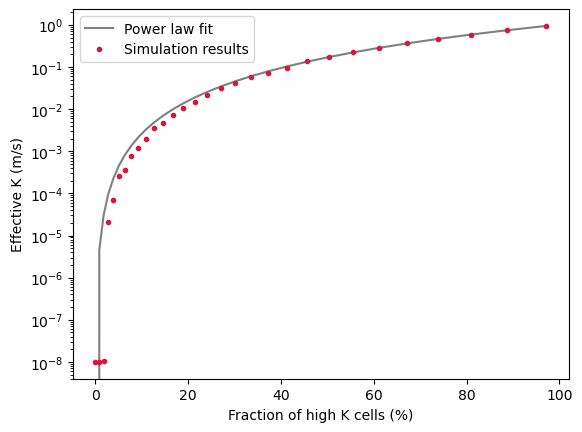

In [67]:
plt.plot(frac_high_k, power_law(frac_high_k, *popt), color='grey', label='Power law fit')
plt.plot(frac_high_k, k_eff_list, linewidth=0, marker='.', label='Simulation results', color='crimson')
plt.semilogy()

plt.xlabel('Fraction of high K cells (%)')
plt.ylabel('Effective K (m/s)')
plt.legend()